# Omitted Results for Equivalence Testing

Here we will briefly run through the code and present the results on the omitted tests in section 4.3 of the thesis.

In [1]:
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm

First, we create the corresponding samples through the following mechanisms:

In [ ]:
#Create sample hiring data

def hiring_data(shift, n=10000,d=0.09):
    
    np.random.seed(36)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
    Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02+d,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    elif shift == 2:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U+0.5))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    elif shift == 3:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,0.3*X+(1/5)*Z+(1/4)*W+0.02,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2



In [12]:
import warnings
warnings.filterwarnings('ignore')

#Define function to perform weighted bootstrap test
def equiv_bootstrap_test_schrouff(sample_a,sample_b,target, causal_parents_source, B=10000, split=0.75,lower_delta = -0.01, upper_delta = 0.01):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    differences = np.empty(B)
    #Step2: perform bootstrap
    
    if len(causal_parents_source) >0:

        for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
            #Test, for each bootstrap iteration have a different set for weights and testing
            #Step 2.1: Sample with replacement from the weights and testing
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            #Step 2.2: Fit logistic regression model to estimate weights
            ##Pool the samples
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            ##Add sample indicator
            pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
            ##Feature matrix X with intercept
            X = sm.add_constant(pooled_weights[causal_parents_source])
            ##Target vector Y with sample 1 as reference
            Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
            ##Fit logistic regression model
            logit_model = sm.Logit(Y, X).fit(disp=0)
            ##extract weights on testing set
            X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
            X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
            p_a = logit_model.predict(X_a)
            p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
            p_b = logit_model.predict(X_b)
            #Store the mean probability for p_a
            if np.any(p_a == 0) or np.any(p_b == 0):
                print('Warning: Zero values in p_a or p_b')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
                print('Warning: Near-zero values in p_a or p_b')
            #Compute the weights
            w_a = 1/p_a
            w_b = 1/p_b
            #Normalize the weights
            w_a_norm = w_a/np.sum(w_a)
            w_b_norm = w_b/np.sum(w_b)
            #Check for nans and infs
            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print('Warning: NaN values in w_a or w_b')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print('Warning: Inf values in w_a or w_b')
            #Check for very small values
            if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
                print('Warning: Near-zero values in w_a or w_b')
            
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            product_a = w_a_norm.values*Y_a
            product_b = w_b_norm.values*Y_b
            sum_a = np.sum(product_a)
            sum_b = np.sum(product_b)
            difference = sum_a - sum_b
            differences[i] = difference

            '''
            together = np.concatenate([product_a,-product_b])
            bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
            bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
            '''

    else:
         for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
             #sample with replacement from testing
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)
            #Compute hadamard product
            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            difference = Y_a - Y_b
            differences[i] = np.mean(difference)




    #Compute t-statistic
    _, p_value_lower_delta = ttest_1samp(differences, lower_delta, alternative = 'greater')
    _, p_value_upper_delta = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_lower_delta, p_value_upper_delta, differences
#Draw samples from the data
sample_1, sample_2 = hiring_data(0)
_, sample_3 = hiring_data(1)
_, sample_4 = hiring_data(3)

#Run the test
##For P(X)
target = 'X'
causal_parents_source = []
_, p_value_x_s1s2_lower, p_value_x_s1s2_upper, differences_x_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source)
_, p_value_x_s1s3_lower, p_value_x_s1s3_upper, differences_x_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
_, p_value_x_s1s4_lower, p_value_x_s1s4_upper, differences_x_s1s4 = equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source)
##For P(Z|X)
target = 'Z'
causal_parents_source = ['X']
_, p_value_z_s1s2_lower, p_value_z_s1s2_upper, differences_z_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source,split = 0.5)
_, p_value_z_s1s3_lower, p_value_z_s1s3_upper, differences_z_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
_, p_value_z_s1s4_lower, p_value_z_s1s4_upper, differences_z_s1s4 = equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source)
##For P(W|X,Z)
target = 'W'
causal_parents_source = ['X','Z']
_, p_value_w_s1s2_lower, p_value_w_s1s2_upper, differences_w_s1s2 = equiv_bootstrap_test_schrouff(sample_1, sample_2, target, causal_parents_source,split = 0.5)
_, p_value_w_s1s3_lower, p_value_w_s1s3_upper, differences_w_s1s3 = equiv_bootstrap_test_schrouff(sample_1, sample_3, target, causal_parents_source)
_, p_value_w_s1s4_lower, p_value_w_s1s4_upper, differences_w_s1s4 = equiv_bootstrap_test_schrouff(sample_1, sample_4, target, causal_parents_source)


Bootstrapping: 100%|██████████| 10000/10000 [05:50<00:00, 28.52it/s]


## Omitted Results Visualized
Note that due to this example being synthetic we have set a seed for reproducibiility. This in turn means that given that all the conditionals tested above come are drawn from the same structural mechanisms, the results will be the same no matter which sample we compare against sample 1. Thus, it suffices to only compare one of either sample 3 or sample 4 against sample 1.  

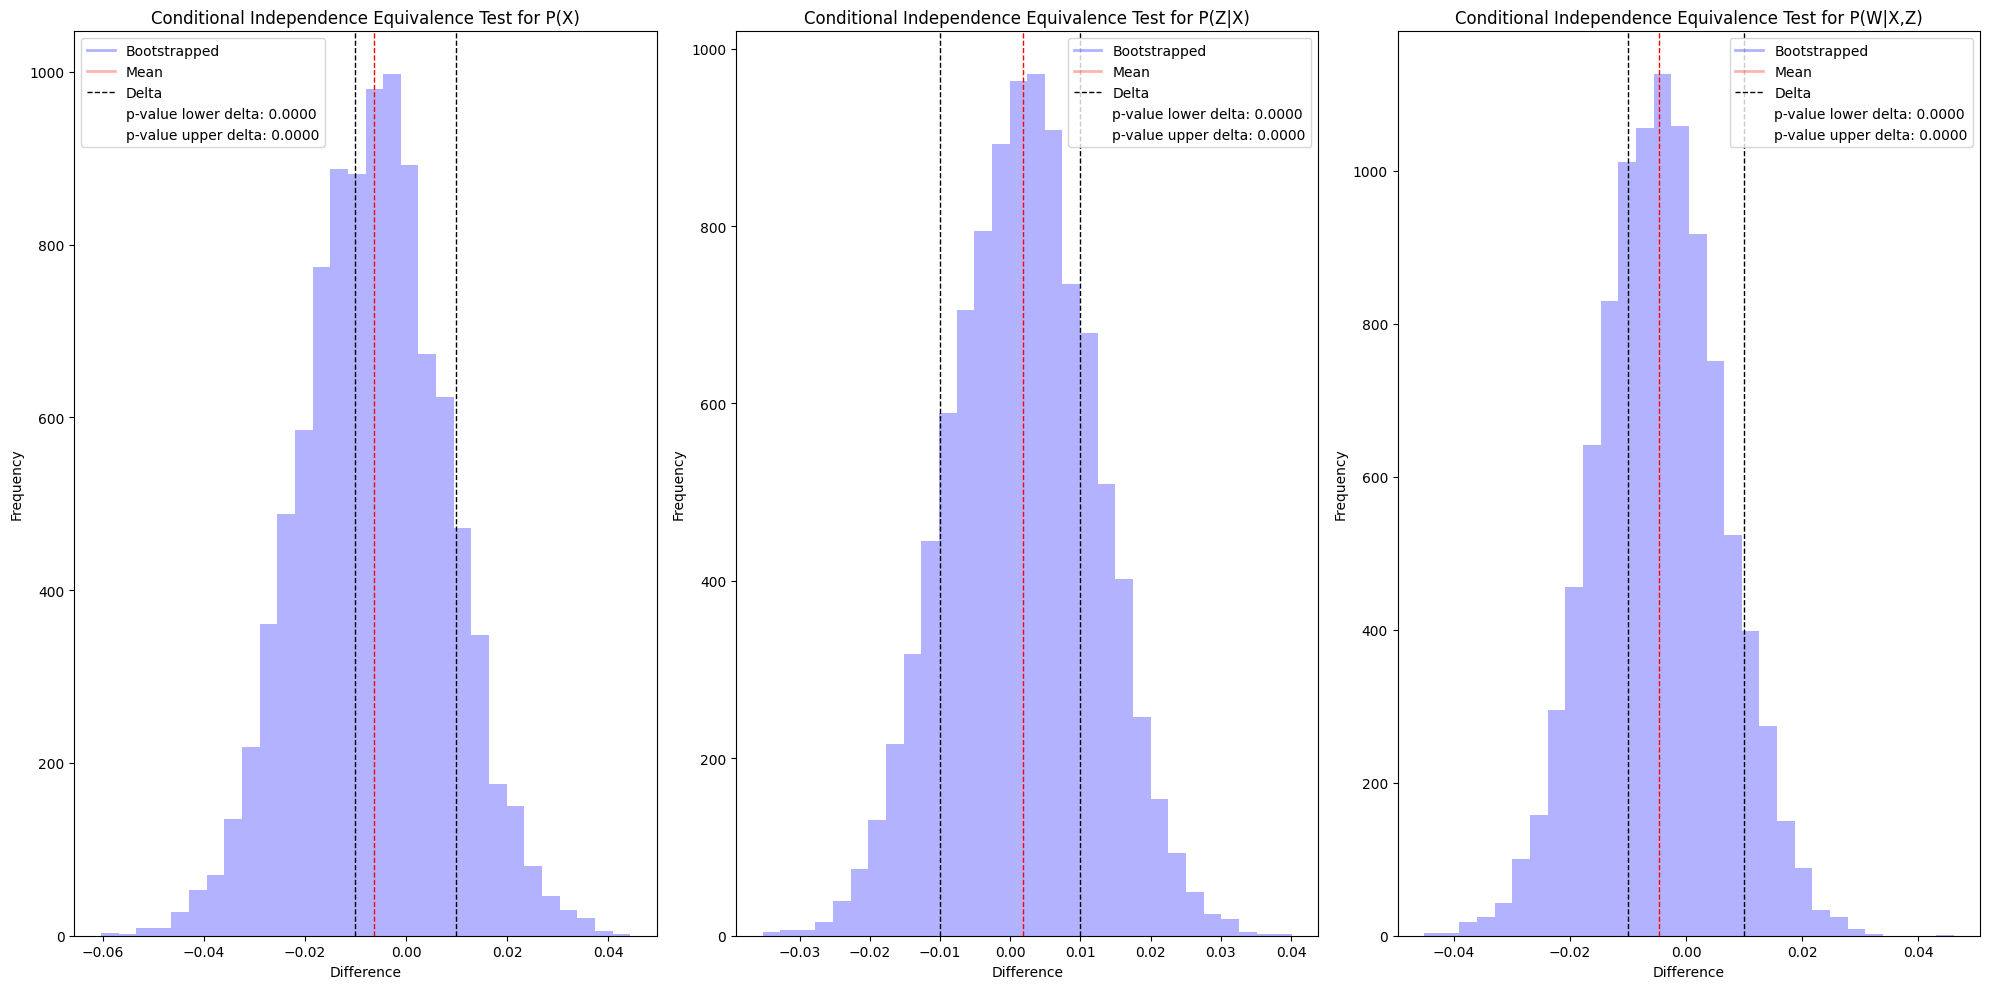

In [13]:
#Histograms for the test results for sample 1 vs sample 2
fig, ax = plt.subplots(1,3, figsize=(20,10))
#Plot for X variable
ax[0].hist(differences_x_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[0].axvline(np.mean(differences_x_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[0].set_title(f"Conditional Independence Equivalence Test for P(X)")
ax[0].set_xlabel("Difference")
ax[0].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[0].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[0].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_x_s1s2_lower:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_x_s1s2_upper:.4f}')])
#Plot for Z variable
ax[1].hist(differences_z_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[1].axvline(np.mean(differences_z_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[1].set_title(f"Conditional Independence Equivalence Test for P(Z|X)")
ax[1].set_xlabel("Difference")
ax[1].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[1].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[1].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_z_s1s2_lower:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_z_s1s2_upper:.4f}')])
#Plot for W variable
ax[2].hist(differences_w_s1s2, bins=30, alpha=0.3, color='blue', label = "Bootstrapped differences")
ax[2].axvline(np.mean(differences_w_s1s2), color='red', linestyle='dashed', linewidth=1, label = "Mean difference")
ax[2].set_title(f"Conditional Independence Equivalence Test for P(W|X,Z)")
ax[2].set_xlabel("Difference")
ax[2].set_ylabel("Frequency")
#Add the lower and upper delta values as vertical lines
ax[2].axvline(-0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
ax[2].axvline(0.01, color='black', linestyle='dashed', linewidth=1, label = "Delta")
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean',alpha = 0.3), plt.Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label='Delta')]
ax[2].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value lower delta: {p_value_w_s1s2_lower:.4f}'), plt.Line2D([0], [0], color='none', label=f'p-value upper delta: {p_value_w_s1s2_upper:.4f}')])
plt.tight_layout()
plt.show()


The results indicate that indeed using the heuristic described in the thesis, we would conclude that there is no distribution shift between the two samples concerning the tested conditionals. More specifically, the test indicates that any difference is likely to fall between $\Delta= [-0.01.+0.01]$.